<h3>"Call a daggum timeout!"</h3>

-Roy Williams, probably never

Basketball fans generally believe that calling timeouts can slow or stop scoring runs. Certain coaches (famously, Roy Williams) are often criticized for not calling timeouts in an attempt to end runs. However, to the best of my knowledge, this general wisdom has never been tested nor supported by any actual analysis. I intended to use a large data set and some straightforward statistical analysis to show that  calling timeouts midgame to end scoring runs has minimal effect on stopping scoring runs and, ultimately, has no effect on winning games.

Scoring runs are expected in any contest just by chance. This can easily be seen from simple coin flips. If a team is expected to convert 50% of possessions (equivalent to a coin flip), then they can be expected to convert several in a row while the other team converts none. In this way, scoring runs should expected to occur in most basketabll contests. Far too much emphasis is placed on "momentum" and players should be expected to recognize these "slumps" and "streaks" as statistically probable events. these scoring streaks and slumps should be expected to regress to the mean over time, ending naturally.

Here, I briefly provide a simple tool to show these probabilities.

In [1]:
# Simulate 10 possessions by each team assuming that each team has a 50% chance to score on every possession (ppp = 1)
from random import randint
team1 = []
team2 = []
for i in range(10):
    # Making scorse worth 2
    team1.append(randint(0,1)*2)
    team2.append(randint(0,1)*2)
print("Team 1", team1, "Final score", sum(team1))
print("Team 2", team2, "Final score", sum(team2))

# My first actual test of this code produced these scores, where Team 2 managed to score 3 unanswered baskets
# Team 1 [2, 0, 2, 0, 0, 0, 2, 2, 0, 0] Final score 8
# Team 2 [2, 0, 2, 2, 2, 2, 2, 2, 0, 0] Final score 14

# This is the primary criteria we use to describe a scoring run - 3 answered baskets

Team 1 [2, 2, 0, 0, 2, 2, 2, 0, 2, 2] Final score 14
Team 2 [2, 2, 0, 0, 0, 0, 0, 2, 2, 2] Final score 10


In [2]:
# Now, we calculate the likelihood that any complete game results in a run of this nature
# We use 70 as the median number of possession in a college basketball game and calculate
# (from https://www.teamrankings.com/ncaa-basketball/stat/possessions-per-game)

runcount = 0
# Number of games to count
for j in range(50):
    team1 = []
    team2 = []
    # Number of poessessions per game
    for i in range(70):
        team1.append(randint(0,1)*2)
        team2.append(randint(0,1)*2)
    # You can print these scores if you would like...
    #print("Team 1", team1, "Final score", sum(team1))
    #print("Team 2", team2, "Final score", sum(team2))
    lastdiff = -1
    team1run = 0
    team2run = 0
    # To determine if a scoring run is occuring, we want the point margin to increase monotonoically (in the same direction).
    # This code simply counts the number of times 1 team has scored when the other did not score.
    # If one team scores 3 baskets in a row with the other team not scoring, we count a run.
    # We are being very conservative here and reseting the count if both teams score or neither team scores.
    # More advanced analysis is used below.
    for score in zip(team1,team2):
        if score[0] > score[1]:
            team1run += 1
            team2run = 0
        elif score[0] < score[1]:
            team2run += 1
            team1run = 0
        else:
            team1run = 0
            team2run = 0
        if team1run >= 3 or team2run >= 3:
            runcount += 1
            # We break after a run is found because we are looking for proportions of games not total number of runs
            # Many games will have multiple runs 
            break
           
# Probability that a scoring run occurs 
print(runcount/50)

0.86


Additionally, scoring runs may simply be a consequence of a team being better than another. If you change the 50% conversions by both teams to 75% for one team and 25% for the other, the occurance of scoring runs drastically increases. Timeouts to end runs may simply be a last-ditch effort to recover from a losing effort and ultimately have no effect on the outcome of the game. In contrast, well-matched teams can expect regression to the mean despite momentary setbacks. 

In [3]:
# This situation is exacerbated if the teams are unequal, basically yielding unity
runcount = 0
for j in range(50):
    team1 = []
    team2 = []
    for i in range(70):
        team1.append(2 if randint(0,3) > 0 else 0)  # 75% of posessions result in scores
        team2.append(2 if randint(0,3) > 2 else 0)  # 25% of posessions result in scores
    # You can print these scores if you would like...
    #print("Team 1", team1, "Final score", sum(team1))
    #print("Team 2", team2, "Final score", sum(team2))
    lastdiff = -1
    team1run = 0
    team2run = 0
    for score in zip(team1,team2):
        if score[0] > score[1]:
            team1run += 1
            team2run = 0
        elif score[0] < score[1]:
            team2run += 1
            team1run = 0
        else:
            team1run = 0
            team2run = 0
        if team1run >= 3 or team2run >= 3:
            runcount += 1
            # We break after a run is found because we are looking for proportions of games not total number of runs
            break
            
print(runcount/50)

1.0


Now, this was a simple exercise to convince those without statistics experience that these claims are true (and also to provide a basis for simulating entire games including factors such as turnovers, 3s, fouls, etc.). 

Those with statistics experience will recognize a binomial distribution. Specific solutions for these cases can be easily calculated. Here's a nice video giving a bit of an explanation: <a href="https://www.youtube.com/watch?v=WWv0RUxDfbs">Binomial distribution | Probability and Statistics | Khan Academy</a>. Note that there are many, many resources for this information. My goal here is to show using real data that these statistical properties are not signficantly affected by timeout strategies, not to show that the binomial distribution is real.

There are other considerations in real basketball games. For example, basketball has very frequent time stoppages. In this analysis, stoppages other than timeouts will not be included as causes for "settling" a run, but it stands to reason that timeouts become even less necessary when other time stoppages are considered as the break in play gives time for quick communication from a coach, substitition for tired/injured/otherwise hindered players, and, more importantly, settling frazzled players, which is the most common justification for this strategy.

To perform this analysis, we first need to objectively identify the beginnings of runs. Then, we need to determine what consistitutes the end of a run. Using this information and Bayes' Theorem, we'll determine if calling a timeout helped to stop the run or affected the outcome of the game.

In future works, I'd like to explore whether my conjecture about the positive effects of other stoppages in play (fouls, out of bounds) is true. Additionally, I believe that experience, i.e., "playing through" a cold streak or weathering a run towards the ends of games, results in increased overall win percentage and, in particular, post-season success. I'd like to perform a similar analysis on games lost due to running out of timeouts.

First, we need to import modules and load some dictionaries. The data were scrapped from ESPN's play-by-play reports for each game. The webscraping code is available on my github. The dictionaries contain relationships between team name, team abbreviation and ESPN's internal code for each team.

In [4]:
import sys
sys.path.append("/home/me/mypy")

import pandas as pd
import numpy as np
import MFLibrary as mf
import matplotlib.pyplot as plt
import sqlite3
from run_finder.team_dict_functions import *

ABRDict = mf.csv.read_dictionary('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\espn_scraper\\ABRdictionary.csv')
NUMDict = mf.csv.read_dictionary('C:\\Dropbox\\Dropbox\\HAXz\\CBBTO\\espn_scraper\\NUMdictionary.csv')


The play-by-play data are stored in a database. As discussed above, we are only taking scoring events and timeouts. There is also a list of game ids that are excluded due to errors in the source data. There are a number of causes that make the data unuseable. In some cases, scores were only added to one team, resulting in games with final scores of, for example, 163-0. Game events were occasionally duplicated, out of order, or given the same time stamp for several consecutive events. The discovery of these games is dicussed below. Bad games are removed completely as the entire set is unreliable. 

In [5]:
conn = sqlite3.connect('C:\Dropbox\Dropbox\HAXz\CBBTO\data\CBBdb.sqlite3')
curr = conn.cursor()
# Exclude unused events - also typo in rebound in a few instances

data = pd.read_sql_query("""SELECT rowid, *
                        FROM playbyplay
                        WHERE LOWER(event) not like '%free throw%'
                        AND (LOWER(event) like '% made %' OR LOWER(event) like '% timeout%')                       
                        AND game_id not in ('253240066', '253510006', '260692440', '283190221',
                        '283192166', '283190201', '293170264', '283342390', '293172633', 303172239, 290450275,
                        280472483, 283472390, 290450275, 290650087, 293170041, 260280218, 263240150, 270170222,
                        400498526, 400591228)""", conn)

all_data = pd.read_sql_query("""SELECT rowid, *
                        FROM playbyplay""", conn)

conn.close()

# Ensure that numbers are numeric values and not strings.
data = data.apply(pd.to_numeric,errors='ignore')
all_data = all_data.apply(pd.to_numeric,errors='ignore')

In [6]:
# Preview the data to esnure that everything was imported correctly
data.head(2)

,rowid,game_id,date,event_index,time,actor,event,away,home,away_score,home_score
0,2,253120183,2005-11-09,1,1176,183,Louie McCroskey made Three Point Jumper.,BCU,SYR,0,3
1,5,253120183,2005-11-09,4,1146,183,Demetris Nichols made Three Point Jumper.,BCU,SYR,0,6


In [7]:
data.describe()

,rowid,game_id,event_index,time,actor,away_score,home_score
count,3.455440e+05,3.455440e+05,345544.000000,345544.000000,345544.000000,345544.000000,345544.000000
mean,8.209610e+05,3.001489e+08,153.150224,579.691122,887.714120,33.078641,37.676990
std,4.937919e+05,3.829551e+07,93.115890,343.998985,1062.219328,20.627207,22.892469
min,2.000000e+00,2.531202e+08,0.000000,0.000000,-1.000000,0.000000,0.000000
25%,3.906478e+05,2.734203e+08,73.000000,272.000000,127.000000,16.000000,18.000000
50%,7.929240e+05,2.932424e+08,151.000000,578.000000,238.000000,32.000000,36.000000
75%,1.251009e+06,3.102902e+08,226.000000,886.000000,2250.000000,49.000000,55.000000
max,1.704480e+06,4.008704e+08,642.000000,1200.000000,3106.000000,123.000000,143.000000


We need to divide games into periods so that we don't span periods or different games. Separating games into periods ensures that clock behavior is consistent and that score differentials are not calculated across periods or games.

In [8]:
# Add each half/ot to periods list
periods = []
lastindex = 0
lasttime = data.iloc[0]['time']
for i, row in data.iterrows():   
    time = row['time']     
    if time > lasttime:
        periods.append(data[lastindex:i])
        if len(periods[-1]) == 0:
            print(lastindex)
        lastindex = i
    lasttime = time
    # See if we can identify the empty dataframe

    
#Add the last period     
periods.append(data[lastindex:i])

Now, we record the change in the score margin ($\Delta scoremargin$) between the two teams. We are interested in scoring runs, which we will identify as increases in the absolute value of $\Delta scoremargin$ (that is, one team is scoring more points than the other and increasing/decreasing the score margin).

First, we exclude the ends of periods because timeout usage and general clock management change dramatically towards the ends of games. As mentioned previously, I would like to explore this time period in the future, as one of the proposed strategic elements of timeouts is preserving them for the ends of games.

Then, we record the score difference between the two teams (not the change in score differe, i.e., $\Delta scoremargin$, but simply the margin in the score $scoremargin$). A positive value indicates that the home team is winning.

Now, we find $\Delta scoremargin$ by calculating the difference between the score margins at two different times. As discussed above, each event is either a made basket or a timeout. In this work, we calculate the difference in margin across 3 events because we are using $\Delta scoremargin >= 6$ across three events (timeouts and made baskets) as our criteria for a run. Based on manual inspection, the sequences identified by this algorithm tend to feel like runs. The requirement for both consecutive baskets and increased score margin prevent trading free throws for field goals being falsely identified as a run.

For example, if a game begins with a score of 0-0, the $score margin$ is zero. Three "events" later, the score is 3-4 (one 3pt and two 2pts) and the $score margin$ is -1 $(3 - 4 = -1)$. Thus, the change in the score difference ($\Delta scoremargin$) is -1 $(-1 - 0 = -1)$. Then, three more events later, the score is 3-10. The score difference is -7 $(3 - 10 = -7)$ and $\Delta scoremargin$ is -6 $(-7 - (-1) = -6)$. That is, the difference in score has increased by -6 (negative indicates away team). This value, $|\Delta scoremargin|$ >= 6, represents the minimum criteria for a run to start. The analysis gives the same absolute value if the scores were reversed (i.e., the home team went on the run).

Note that free throws are not included as events in this analysis but the points are included. That is, free throws can prevent the start of a scoring run even if a team makes no field goals. For example, if a team scores 3 consecutive baskets, but fouls on every possesion at the other end, $|\Delta scoremargin|$ could be less than 6, and we do not consider this sequence of events to represent a scoring run. Alternatively, a team may not need three consecutive baskets to start a scoring run. For example, two 3pts and an opposing 2pt could start a run if the opposing team also fouled in that time frame. More precise results may be attainable if these types of cases are addressed.

In [9]:
# Calculating the quantities described above.

differences = []
# This list and dictionar are used to calculate the average score margin
# Based on the above analysis and as will be discussed below, we only
# want to analyze games that were competitive because scoring streaks are very common
# in games where teams are not comptetitive.
# We use a dictionary so we can identify game by game avarage score margins.
score_margin_dict = {}
# The list is only used to investigate the data
score_margin_list = []
# We could eliminate games based on margins here to speed up the analysis
# but I'm leaving all of the data in the analysis as long as possible in case the
# approach needs to change or the specific cutoff criteria change.

for period in periods:
    # Drop ends of periods because strategy can change
    period = period.loc[period['time'] > 90]
    
    # Current score margin
    # Will be used with diff below to calculate change in score difference
    period['delta_score_margin'] = period['home_score'] - period['away_score']
    try:
        x = period['game_id'].values[0]
    except:
        print(period)
        
    try:
        average_score_margin = period['delta_score_margin'].mean()
        score_margin_list.append(average_score_margin)
        score_margin_dict[period['game_id'].values[0]] = average_score_margin
    except:
        continue
    
    # Get delta time and delta score difference
    difference = period[['time','delta_score_margin']].diff(3)
    # Pass data forward
    difference['row_id'] = period['rowid']
    difference['game_id'] = period['game_id']
    difference['event'] = period['event']
    difference['actor'] = period['actor']
    difference['home'] = period['home']
    difference['away'] = period['away']
    difference['home_score'] = period['home_score']
    difference['away_score'] = period['away_score']
    difference['score_margin'] = period['home_score'] - period['away_score']
    
    # Passage of time (delta_time) should be positive but difference is calculated from a counting down clock.
    difference['delta_time'] = -difference['time']
    difference['time'] = period['time']
    
    
    difference = difference.replace([np.inf, -np.inf], np.nan)
    difference = difference[['game_id','row_id','event','actor','home','away','home_score', 'away_score','score_margin','time','delta_time','delta_score_margin']].dropna()
    differences.append(difference)

# We can combine all of these values into one dataframe again because we no longer have to worry about overlapping adjacent events 
result = pd.concat(differences)

c:\program files (x86)\python36-32\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Empty DataFrame
Columns: [rowid, game_id, date, event_index, time, actor, event, away, home, away_score, home_score, delta_score_margin]
Index: []
Empty DataFrame
Columns: [rowid, game_id, date, event_index, time, actor, event, away, home, away_score, home_score, delta_score_margin]
Index: []


Now, we examine our data to make sure it all makes sense. I've already excluded many games (see list above in the SQL query) because they were identified using these techniques to have corrupted data.

In [10]:
# We start with the average score margin which we will use to eliminate blow out games
score_margin_df = pd.DataFrame({'scores':score_margin_list})
score_margin_df.describe()

,scores
count,11252.000000
mean,4.242591
std,10.634862
min,-37.760870
25%,-2.115950
50%,3.000000
75%,9.400000
max,67.729730


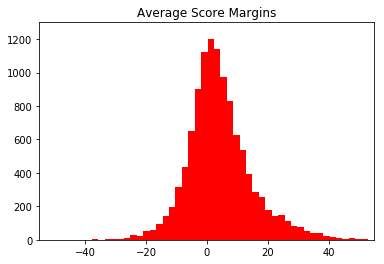

In [11]:
# Everything looks pretty normal here. 
# As will be common, there is a slight skew toward the home team.
fig = plt.figure()
plt.ylim([0,1300])
plt.xlim([-55,55])
plt.hist(score_margin_df.scores.dropna(), bins=50, color='r', alpha=1, label='diff')
plt.title("Average Score Margins")
plt.show()

In [12]:
# On to the analysis data
result.describe()

,game_id,row_id,actor,home_score,away_score,score_margin,time,delta_time,delta_score_margin
count,2.815740e+05,2.815740e+05,281574.000000,281574.000000,281574.000000,281574.000000,281574.000000,281574.000000,281574.000000
mean,3.000994e+08,8.201516e+05,888.835230,37.622618,32.815739,4.806878,577.182989,110.347813,0.375322
std,3.828543e+07,4.934950e+05,1062.855368,21.899508,19.450646,12.019807,283.444790,50.112198,3.199834
min,2.531202e+08,7.000000e+00,-1.000000,0.000000,0.000000,-53.000000,91.000000,-0.000000,-15.000000
25%,2.734203e+08,3.904832e+05,127.000000,18.000000,16.000000,-3.000000,330.000000,74.000000,-2.000000
50%,2.932401e+08,7.917835e+05,236.000000,36.000000,31.000000,4.000000,575.000000,102.000000,0.000000
75%,3.102902e+08,1.249264e+06,2250.000000,54.000000,48.000000,11.000000,823.000000,138.000000,3.000000
max,4.008704e+08,1.704465e+06,3106.000000,141.000000,120.000000,83.000000,1181.000000,726.000000,16.000000


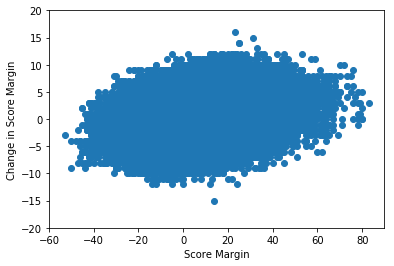

In [13]:
plt.scatter(result['score_margin'],result['delta_score_margin'])
plt.ylim([-20,20])
plt.xlabel('Score Margin')
plt.ylabel('Change in Score Margin')
plt.show()

In [14]:
# We manually investigate the games 
result.loc[(result['delta_score_margin'] > 20)]

# We can use the code in the next cell to look at specific games 
# all_data.loc[(all_data.game_id == 253130183)]
# or the link
# http://www.espn.com/mens-college-basketball/playbyplay?gameId=400872229
# substituting in the game_id

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin


In [15]:
#all_data.loc[(all_data.game_id == 253130183)]

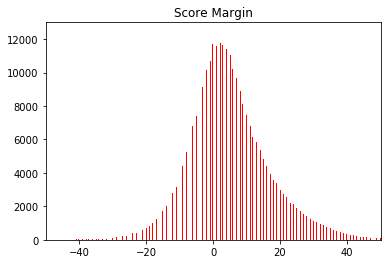

In [16]:
fig = plt.figure()
plt.ylim([0,13000])
plt.xlim([-50,50])
plt.hist(result['score_margin'], bins=500, color='r', alpha=1, label='diff')
plt.title("Score Margin")
plt.show()

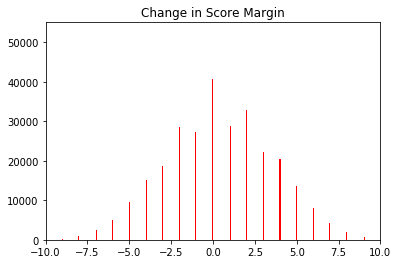

In [17]:
fig = plt.figure()
plt.ylim([0,55000])
plt.xlim([-10,10])
plt.hist(result['delta_score_margin'], bins=500, color='r', alpha=1, label='diff')
plt.title("Change in Score Margin")
plt.show()
# 1pt score differentials are slightly depressed as expected

In [18]:
# The pd.diff calculation above can be somewhat slow, so we can save the results here to speed up analysis.

#result.to_csv('run_calculation_diff3.csv', encoding='utf-8')
#result = pd.read_csv('run_calculation_diff3.csv', header = 0)

In [19]:
result.head()

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
3,253120183,7,Antonio Webb made Three Point Jumper.,2065,SYR,BCU,6,5,1,1105,71.0,-2.0
4,253120183,12,Demetris Nichols made Three Point Jumper.,183,SYR,BCU,9,5,4,1026,120.0,-2.0
5,253120183,17,Terrence Roberts made Two Point Layup.,183,SYR,BCU,11,5,6,988,137.0,2.0
6,253120183,18,Michael Williams II made Two Point Jumper.,2065,SYR,BCU,11,7,4,968,137.0,3.0
7,253120183,20,Official TV Timeout.,183,SYR,BCU,11,7,4,942,84.0,0.0


In [20]:
# Now, we collect the situations that qualify as runs based on our previous discussion.
runs = result.loc[(result.delta_score_margin > 6) | (result.delta_score_margin < -6)]

In [21]:
runs.head()

,game_id,row_id,event,actor,home,away,home_score,away_score,score_margin,time,delta_time,delta_score_margin
16,253120183,90,Gerry McNamara made Three Point Jumper.,183,SYR,BCU,25,10,15,307,300.0,9.0
17,253120183,91,Bethune Cookm Full Timeout.,2065,SYR,BCU,25,10,15,302,204.0,7.0
72,253130183,415,Terrence Roberts made Two Point Layup.,183,SYR,COR,30,24,6,119,159.0,7.0
79,253130183,446,Ryan Rourke made Two Point Layup.,172,SYR,COR,37,35,2,1068,99.0,-7.0
132,253160277,674,Drew Meyerchick made Three Point Jumper.,2433,WVU,ULM,35,27,8,308,167.0,-7.0


In [ ]:
runs.describe()

,game_id,row_id,actor,home_score,away_score,score_margin,time,delta_time,delta_score_margin
count,1.097600e+04,1.097600e+04,10976.000000,10976.000000,10976.000000,10976.000000,10976.000000,10976.000000,10976.000000
mean,3.019227e+08,8.396290e+05,862.098488,37.413903,30.172923,7.240980,589.821155,136.075346,2.299745
std,3.997584e+07,4.968871e+05,1049.258398,22.558253,19.506447,14.407773,283.446437,50.884924,7.272777
min,2.531202e+08,9.000000e+01,-1.000000,0.000000,0.000000,-50.000000,91.000000,14.000000,-15.000000
25%,2.735602e+08,4.095305e+05,127.000000,18.000000,13.750000,-3.000000,331.750000,99.000000,-7.000000
50%,2.934002e+08,8.288940e+05,235.000000,34.000000,28.000000,7.000000,574.500000,128.000000,7.000000
75%,3.103901e+08,1.271854e+06,2217.000000,54.000000,45.000000,15.000000,824.000000,165.000000,8.000000
max,4.008704e+08,1.704221e+06,3096.000000,134.000000,106.000000,76.000000,1126.000000,550.000000,16.000000


<h2>How do we identify a run as ending?</h2> 

Does a single basket end a run? That seems a bit generous to me.

Does the team that's "slipping" need to make a complete comeback? That seems like a high requirement to me.

I think the natural minimum requirement is returning to trading baskets (i.e., $\Delta scoremargin = 0$). Even if the running team still holds a lead (or made a comeback), the damage is at least somewhat mitigated. However, an informal survey I conducted had suggestions of even lower requirements than trading baskets. Therefore, I am going to explore a range of score ratios as the ending criterion. Using a ratio also includes the minimum requirement that the slipping team scores at least 1 point as otherwise we will produce a divide by zero error (which we just handle and pass as not stopping the run). Based on the criteria, stopping all scoring is also not a valid end of a run; this edge case is highly unlikely and will not be examined further at this time.

The ratio $\frac{runner score}{slipper score} <= 1$ indicates that the slipping team has scored at least as many points as the running team (i.e., trading baskets or better) and is the minium tested value for ending a run. In contrast, the ratio $\frac{runner score}{slipper score} >= 2$ indicates that the running team is scoring points at a 2:1 ratio, which I would contest indicates that the running team is still very much on a run. I maintain that the 1:1 scoring ratio seems best as a criterion for "ending a run", but we will calculate other values for arguments sake.

In the analysis below, we collect the ten scoring and timeout events after a run is considered to have started. We are only interested in the first few possession after a run and subsequent timeout. If a run doesn't end within ten events after the start of the run, it is effectively considered to have not been stopped; I believe this to be a very generous time horizon for a slipping team to end a run. We aren't interested in extending the time to infinity as strategies can change with large leads near the ends of games and nearly all runs will "end" when sufficiently large margins are acheived.

Run are considered over when the score ratio $\frac{runner score}{slipper score} <=$ the indicated ratio (from 1 to 2) or two timeouts are called (as the first timeout is thus deemed inadequate to stop a run). We can differentiate these scenarios based on the type of timeout (runner called, slipper called, or official/TV).

From this information, we are going to caluclate certain probabilities:

1) The overall probability that a run ended (and its inverse that a run does not end).

2) The probability that a timeout was called and the run ended.

3) The probability that a timeout was called and the run did not end.

From these probabilities and Bayes' Theorem, we can calculate the probability that the timeout was responsible for the run ending. In other words, would a stopped run have stopped without the timeout? Frequentist statistics can also be directly observed.

In [ ]:
diff_length = 3 # This value comes from the diff function above. Rhis value could be refactored to be intialized at the start.

different_stop_criteria = []
# Choosing the correct criteria for a run stop is difficult, so I'll go ahead and
# calculate a range so you can argue about it.
run_criteria = [1 + x/10 for x in range(11)]  # Easier than manual input

for run_criterion in run_criteria:
    run_stops = []
    indx = 0
    for i,row in runs.iterrows():
        # If rows are consecutive, they belong to the same run, so we group them and skip ahead
        if result.loc[result.row_id == row['row_id']].index[0] == indx + 1:
            indx = result.loc[result.row_id == row['row_id']].index[0]
            continue

        # We use the index from the original data set to find the events
        indx = result.loc[result.row_id == row['row_id']].index[0]

        # Grab a few extra events - if run doesn't end after 10 baskets or 2 timeouts, it's considered to not end
        working = result.loc[(result.index >= indx - diff_length) & (result.index <= indx + 10)]
        # Reset the index for the slice
        working = working.reset_index()
        del working['index']

        # Collect some values
        run_start_time = row['time']

        team_list = [data.loc[(data.rowid == row['row_id'])]['home'].values[0], data.loc[(data.rowid == row['row_id'])]['away'].values[0]]
        runner_index = 0 if row['delta_score_margin'] > 0 else 1
        runner = team_list[runner_index]

        run_ended = False

        timeouts = []
        score_log = []
        last_time = 1200
        for j,event in working.iterrows():
            # Need to guarntee that we collect these values
            if j == diff_length:
                    run_start_scores = [event['home_score'], event['away_score']]

            # If the slice range crosses a period skip the rows from the old period.
            if run_start_time > event['time'] and j < diff_length:  # Shouldn't happen
                continue

            # Or if the slice crosses ahead into a new period or game, we end the run
            # New period
            if last_time - event['time'] < 0:
                timeouts.append([j, 'End Game', '', ''])
                break
            last_time = event['time']
            # New game - should get caught by new conditional above but just in case
            if event['home'] not in team_list:
                timeouts.append([j, 'End Game', '', ''])
                break

            if 'timeout' in event['event'].lower():
                # If we get a second stop in play after the run starts, we are going to consider the run not stopped
                attempt_stop = 0
                if j > diff_length:
                    attempt_stop += 1
                if timeouts:
                    for timeout in timeouts:
                        if timeout[0] > diff_length:  # We don't want to stop the run for TOs during the build up
                            attempt_stop += 1
                # We don't break here as we might want to know about this timeout. We'll break after adding the TO info.

                # Check if timeout caller is winning
                try:
                    caller = NUMDict[str(event['actor'])]
                except:
                    caller = 'error'
                # ESPN doesn't use a separate icon for official TOs, instead just using one of the teams
                # We manually override this flaw.
                if ' tv ' in event['event'].lower():
                    caller = 'tv'
                # Identify currently winning team
                is_winning = caller == ABRDict[team_list[0] if event['home_score'] - event['away_score']  >= 0 else team_list[1]]
                # Check if the TO caller is the team that is running (unlikely)
                is_running = caller == ABRDict[runner] # tv == False
                timeouts.append([j, caller, is_winning, is_running, [event['home_score'], event['away_score']]])
                if attempt_stop >= 2:  # But if we have two TOs during a run, we are going to consider it not stopped
                    break
                # No scoring occurred so we don't need to finish the loop (prevent duplicates from being added to score_log)
                continue 
            else:
                score_log.append([j,[event['home_score'],event['away_score']]])

            if j > diff_length + 4 and len(score_log) > 2:
                # Slipping team made somewhat of a comeback 
                # (0 - 1 = -1 == 1 in two item list)
                slipper_score_margin = score_log[-1][1][runner_index-1] - run_start_scores[runner_index-1]
                runner_score_margin = score_log[-1][1][runner_index] - run_start_scores[runner_index]
                try:
                    if runner_score_margin / slipper_score_margin <= run_criterion:
                        run_ended = True
                        break
                except:
                    # If the slipper hasn't scored, we don't care and move on
                    pass

        # Get Final score
        final = all_data.loc[(all_data.game_id == row.game_id)].tail(1)
        final_scores = [final['home_score'].values[0], final['away_score'].values[0]]
        # Use final score to determine the index of the winning team
        winner = team_list[0 if (final['home_score'].values > final['away_score'].values) else 1]
        run_stops.append([event.game_id, team_list, winner, runner, run_ended, timeouts, score_log, final_scores])
        
    different_stop_criteria.append([run_criterion, run_stops])

print(different_stop_criteria)
for criterion in different_stop_criteria:
    for row in criterion:
        print(row[1])
        print('======================')


Okay. Now we have the probabilities that we need to use Bayes' Theorem to determine the probability that a timeout has an effect on a scoring run. A very good explanation that can help with intuitive understanding can be found at <a href = 'https://betterexplained.com/articles/an-intuitive-and-short-explanation-of-bayes-theorem/'>betterexplained.com</a>. The theorem will be described briefly here:

$$P(Run Ended | Timeout Called) = \frac{P(Timeout Called | Run Ended)P(Run Ended)}{P(Timeout Called | Run Ended)P(Run Ended) + P(Timeout Called | Run Not Ended)P(Run Not Ended)}$$

where P(Run Ended | Timeout Called) = probability that calling a timeout is responsible for ending a run,

P(Timeout Called | Run Ended) = probability that a timeout was called and the run ended, 

P(Run Ended) = probability that a run ends at all (based on our criteria),

P(Timeout Called | Run Not Ended) = probability that a timeout was called but the run did not end,

and P(Run Not Ended) = probability that the run did not end.

In [ ]:
total_rows = len(run_stops)

run_stopped = 0
timeout_and_run_stopped = 0
tv_timeout_and_run_stopped = 0
slipper_timeout_and_run_stopped = 0
runner_timeout_and_run_stopped = 0

run_not_stopped = 0
timeout_and_run_not_stopped = 0
tv_timeout_and_run_not_stopped = 0
slipper_timeout_and_run_not_stopped = 0
runner_timeout_and_run_not_stopped = 0

for row in run_stops:
    end_game = False
    
    if abs(score_margin_dict[row[0]]) > 5:
        total_rows -= 1
        continue

    # Exclude runs that traverse into end game terroritory
    if row[5]:
        for to in row[5]:
            if to[1] == 'End Game':
                total_rows -= 1
                end_game = True
    if end_game:
        continue
    
    # Run stopped
    if row[4]:
        run_stopped += 1
        # TOs called
        if row[5]: 
            to_counted = False
            for to in row[5]:
                if to[0] > diff_length:
                    if not to_counted:
                        timeout_and_run_stopped += 1
                        to_counted = True
                        if to[1] == 'tv':
                            tv_timeout_and_run_stopped += 1
                        elif not to[3]:
                            slipper_timeout_and_run_stopped += 1
                        elif to[3]:
                            runner_timeout_and_run_stopped += 1

                    
    # Run not stopped
    else:
        run_not_stopped += 1
        # TOs called
        if row[5]:
            to_counted = False
            for to in row[5]:
                if to[0] > diff_length:
                    if not to_counted:
                        timeout_and_run_not_stopped += 1
                        to_counted = True
                        if to[1] == 'tv':
                            tv_timeout_and_run_not_stopped += 1
                        elif not to[3]:
                            slipper_timeout_and_run_not_stopped += 1
                        elif to[3]:
                            runner_timeout_and_run_not_stopped += 1


print('---------------')
print('Run stopped')
print('---------------')
print(run_stopped)
print('{:.1%}'.format(run_stopped/total_rows))
print('---------------')
print('Run not stopped')
print('---------------')
print(run_not_stopped)
print('{:.1%}'.format(run_not_stopped/total_rows))
print('---------------')
print('Timeout and run stopped')
print('---------------')
print(timeout_and_run_stopped)
print('{:.1%}'.format(timeout_and_run_stopped/(timeout_and_run_stopped + timeout_and_run_not_stopped)))
print('---------------')
print('Timeout and run not stopped')
print('---------------')
print(timeout_and_run_not_stopped)
print('{:.1%}'.format(timeout_and_run_not_stopped/(timeout_and_run_stopped + timeout_and_run_not_stopped)))
print('---------------')
print('P(Run Ended|TimeoutCalled)')
print('---------------')
print('{:.1%}'.format((timeout_and_run_stopped * run_stopped)/(timeout_and_run_stopped*run_stopped + timeout_and_run_not_stopped*run_not_stopped)))
        

In [ ]:
print('---------------')
print('Run stopped')
print('---------------')
print(run_stopped)
print('{:.1%}'.format(run_stopped/total_rows))
print('---------------')
print('Run not stopped')
print('---------------')
print(run_not_stopped)
print('{:.1%}'.format(run_not_stopped/total_rows))
print('---------------')
print('Timeout and run stopped')
print('---------------')
print(slipper_timeout_and_run_stopped)
print('{:.1%}'.format(slipper_timeout_and_run_stopped/(slipper_timeout_and_run_stopped + slipper_timeout_and_run_not_stopped)))
print('---------------')
print('Timeout and run not stopped')
print('---------------')
print(slipper_timeout_and_run_not_stopped)
print('{:.1%}'.format(slipper_timeout_and_run_not_stopped/(slipper_timeout_and_run_stopped + slipper_timeout_and_run_not_stopped)))
print('---------------')
print('P(Run Ended|TimeoutCalled)')
print('---------------')
print('{:.1%}'.format((slipper_timeout_and_run_stopped * run_stopped)/(slipper_timeout_and_run_stopped*run_stopped + slipper_timeout_and_run_not_stopped*run_not_stopped)))
        